# Evaluate "LLM as a Judge"

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns

# Configure Matplotlib for inline display
%matplotlib inline

In [111]:
# Choose which llm-as-a-judge data to evaluate
common_path = "../data/evaluations/"

# llm_judge_file = '2024-07-03-output_gpt35.csv'
llm_judge_file = '2024-07-03-output_gpt4.csv'
llm_data = pd.read_csv(common_path + llm_judge_file)

# This is from our sweat blood and tears
human_data = pd.read_csv(common_path + '2024-06-06-human-judge.csv')

# Ensure that the transcript numbers are exactly matched, and are in the same order
llm_data = llm_data.sort_values(by='Transcript Number', ascending=False)
human_data = human_data.sort_values(by='Transcript Number', ascending=False)
assert (llm_data['Transcript Number'] == human_data['Transcript Number']).all()

In [116]:
# display(llm_data.head())

# print all unique values for each column
for col in llm_data.columns:
    print(col, llm_data[col].unique())

Transcript Number [19557627 19516114 18136989 17707918 17566649 15345003 15338322 14807966
 14540393 14185111 13912736 13727871 13727153 13166275 12807868 12390274
 12305811 11242742 11080025 10339317]
Patient Name [1]
Dyspnea (shortness of breath) at rest, while walking or climbing stairs? [1]
Paroxysmal Nocturnal Dyspnea (PND) (sudden shortness of breath at night) [1]
Orthopnea (shortness of breath while lying flat) [0 1]
Ankle edema or general lower extremity swelling (swelling in ankles or legs) [1 0]
Nocturnal cough (coughing at night) [0 1]
Chest pain [0 1]
Fatigue [1 0]
Worsening mental status that is acute (sudden confusion or mental changes) [0 1]
Temperature (body temperature) [1 0]
Heart rate (pulse) [1 0]
Respiratory rate (number of breaths per minute) [1]
Oxygen saturation (oxygen level in the blood) [1]
Blood pressure (systolic and diastolic) (upper and lower blood pressure numbers) [1]
Weight (body weight) [1]
Did the doctor ask the patient what medications they are on? 

In [117]:
# display(human_data.head())

# print all unique values for each column
for col in human_data.columns:
    print(col, human_data[col].unique())

Transcript Number [19557627 19516114 18136989 17707918 17566649 15345003 15338322 14807966
 14540393 14185111 13912736 13727871 13727153 13166275 12807868 12390274
 12305811 11242742 11080025 10339317]
Dyspnea [1]
Paroxysmal Nocturnal Dyspnea (PND) [1 0]
Orthopnea (shortness of breath while lying flat) [1 0]
Ankle edema or general lower extremity swelling (swelling in ankles or legs) [1]
Nocturnal cough (coughing at night) [1 0]
Chest pain [1 0]
Fatigue [1 0]
Worsening mental status that is acute (sudden confusion or mental changes) [1 0]
Temperature (body temperature) [1]
Heart rate (pulse) [1]
Respiratory rate (number of breaths per minute) [1]
Oxygen saturation (oxygen level in the blood) [1]
Blood pressure (systolic and diastolic) (upper and lower blood pressure numbers) [1 0]
Weight (body weight) [1 0]
Meds Score [1]
Did the doctor ask the patient what medications they are on? [1]
Qual Score [3.5 3.  2.5 2.  4.  1.5]
Qual Judge Diff [1 0 2 3]
Be sympathetic when the patient report

In [114]:
columns_matching = {
    "Transcript Number": "transcript_id",
    "Dyspnea": "dyspnea",
    "Paroxysmal Nocturnal Dyspnea (PND)": "pnd",
    'Orthopnea': "orthopnea",
    'Ankle edema or general lower extremity swelling (swelling in ankles or legs)': "ankle_edema",
    'Nocturnal cough (coughing at night)': "nocturnal_cough",
    'Chest pain': "chest_pain",
    'Fatigue': "fatigue",
    'Worsening mental status': "worsening_mental_status",
    'Temperature (body temperature)': "temperature",
    'Heart rate (pulse)': "heart_rate",
    'Respiratory rate (number of breaths per minute)': "respiratory_rate",
    'Oxygen saturation (oxygen level in the blood)': "oxygen_saturation",
    'Blood pressure (systolic and diastolic) (upper and lower blood pressure numbers)': "blood_pressure",
    'Weight (body weight)': "weight",
    'Did the doctor ask the patient what medications they are on?': "doctor_ask_medications",
    'Be sympathetic when the patient reports symptoms or pain.': "sympathetic_patient",
    'Reminder: "Please remember to contact your healthcare provider if you notice any significant changes or worsening of symptoms."': "reminder",
    'End the Conversation: Express care and encourage the patient to reach out if they need further assistance.': "end_conversation",
    'no premature end to conversation': "no_premature_end",
    'Conversation flows naturally: no repetition': "natural_conversation",
    'Patient uses plain language': "plain_language",
    'Patient is consistent about their symptoms': "consistent_symptoms",
    'Patient doesn’t invent information that contradicts the prompt (confabulations)': "no_confabulations",
    'Patient allows the doctor to ask questions and doesn’t take over direction of the conversation (offering information before it’s asked for)': "allow_doctor_questions"
}
short_columns = list(set(columns_matching.values()))
feature_columns = [col for col in short_columns if col not in ['transcript_id']]


def rename_columns(df):
    # find match, but note that columns only need to match the front part
    matched_columns = {}
    for col in df.columns:
        for key, value in columns_matching.items():
            if col.lower().startswith(key.lower()) and col not in matched_columns:
                matched_columns[col] = value
                break

        if col not in matched_columns:
            print(f"Column {col} not matched")
    output_df = df.copy().rename(columns=matched_columns)

    # drop columns that are not matched
    output_df = output_df.drop(columns=[col for col in output_df.columns if col not in short_columns])
    return output_df


llm_data_renamed = rename_columns(llm_data)
human_data_renamed = rename_columns(human_data)

Column Patient Name not matched
Column Meds Score not matched
Column Qual Score not matched
Column Qual Judge Diff not matched
Column Patient Score not matched
Column Patient Judge Diff not matched


/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:716: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Libra

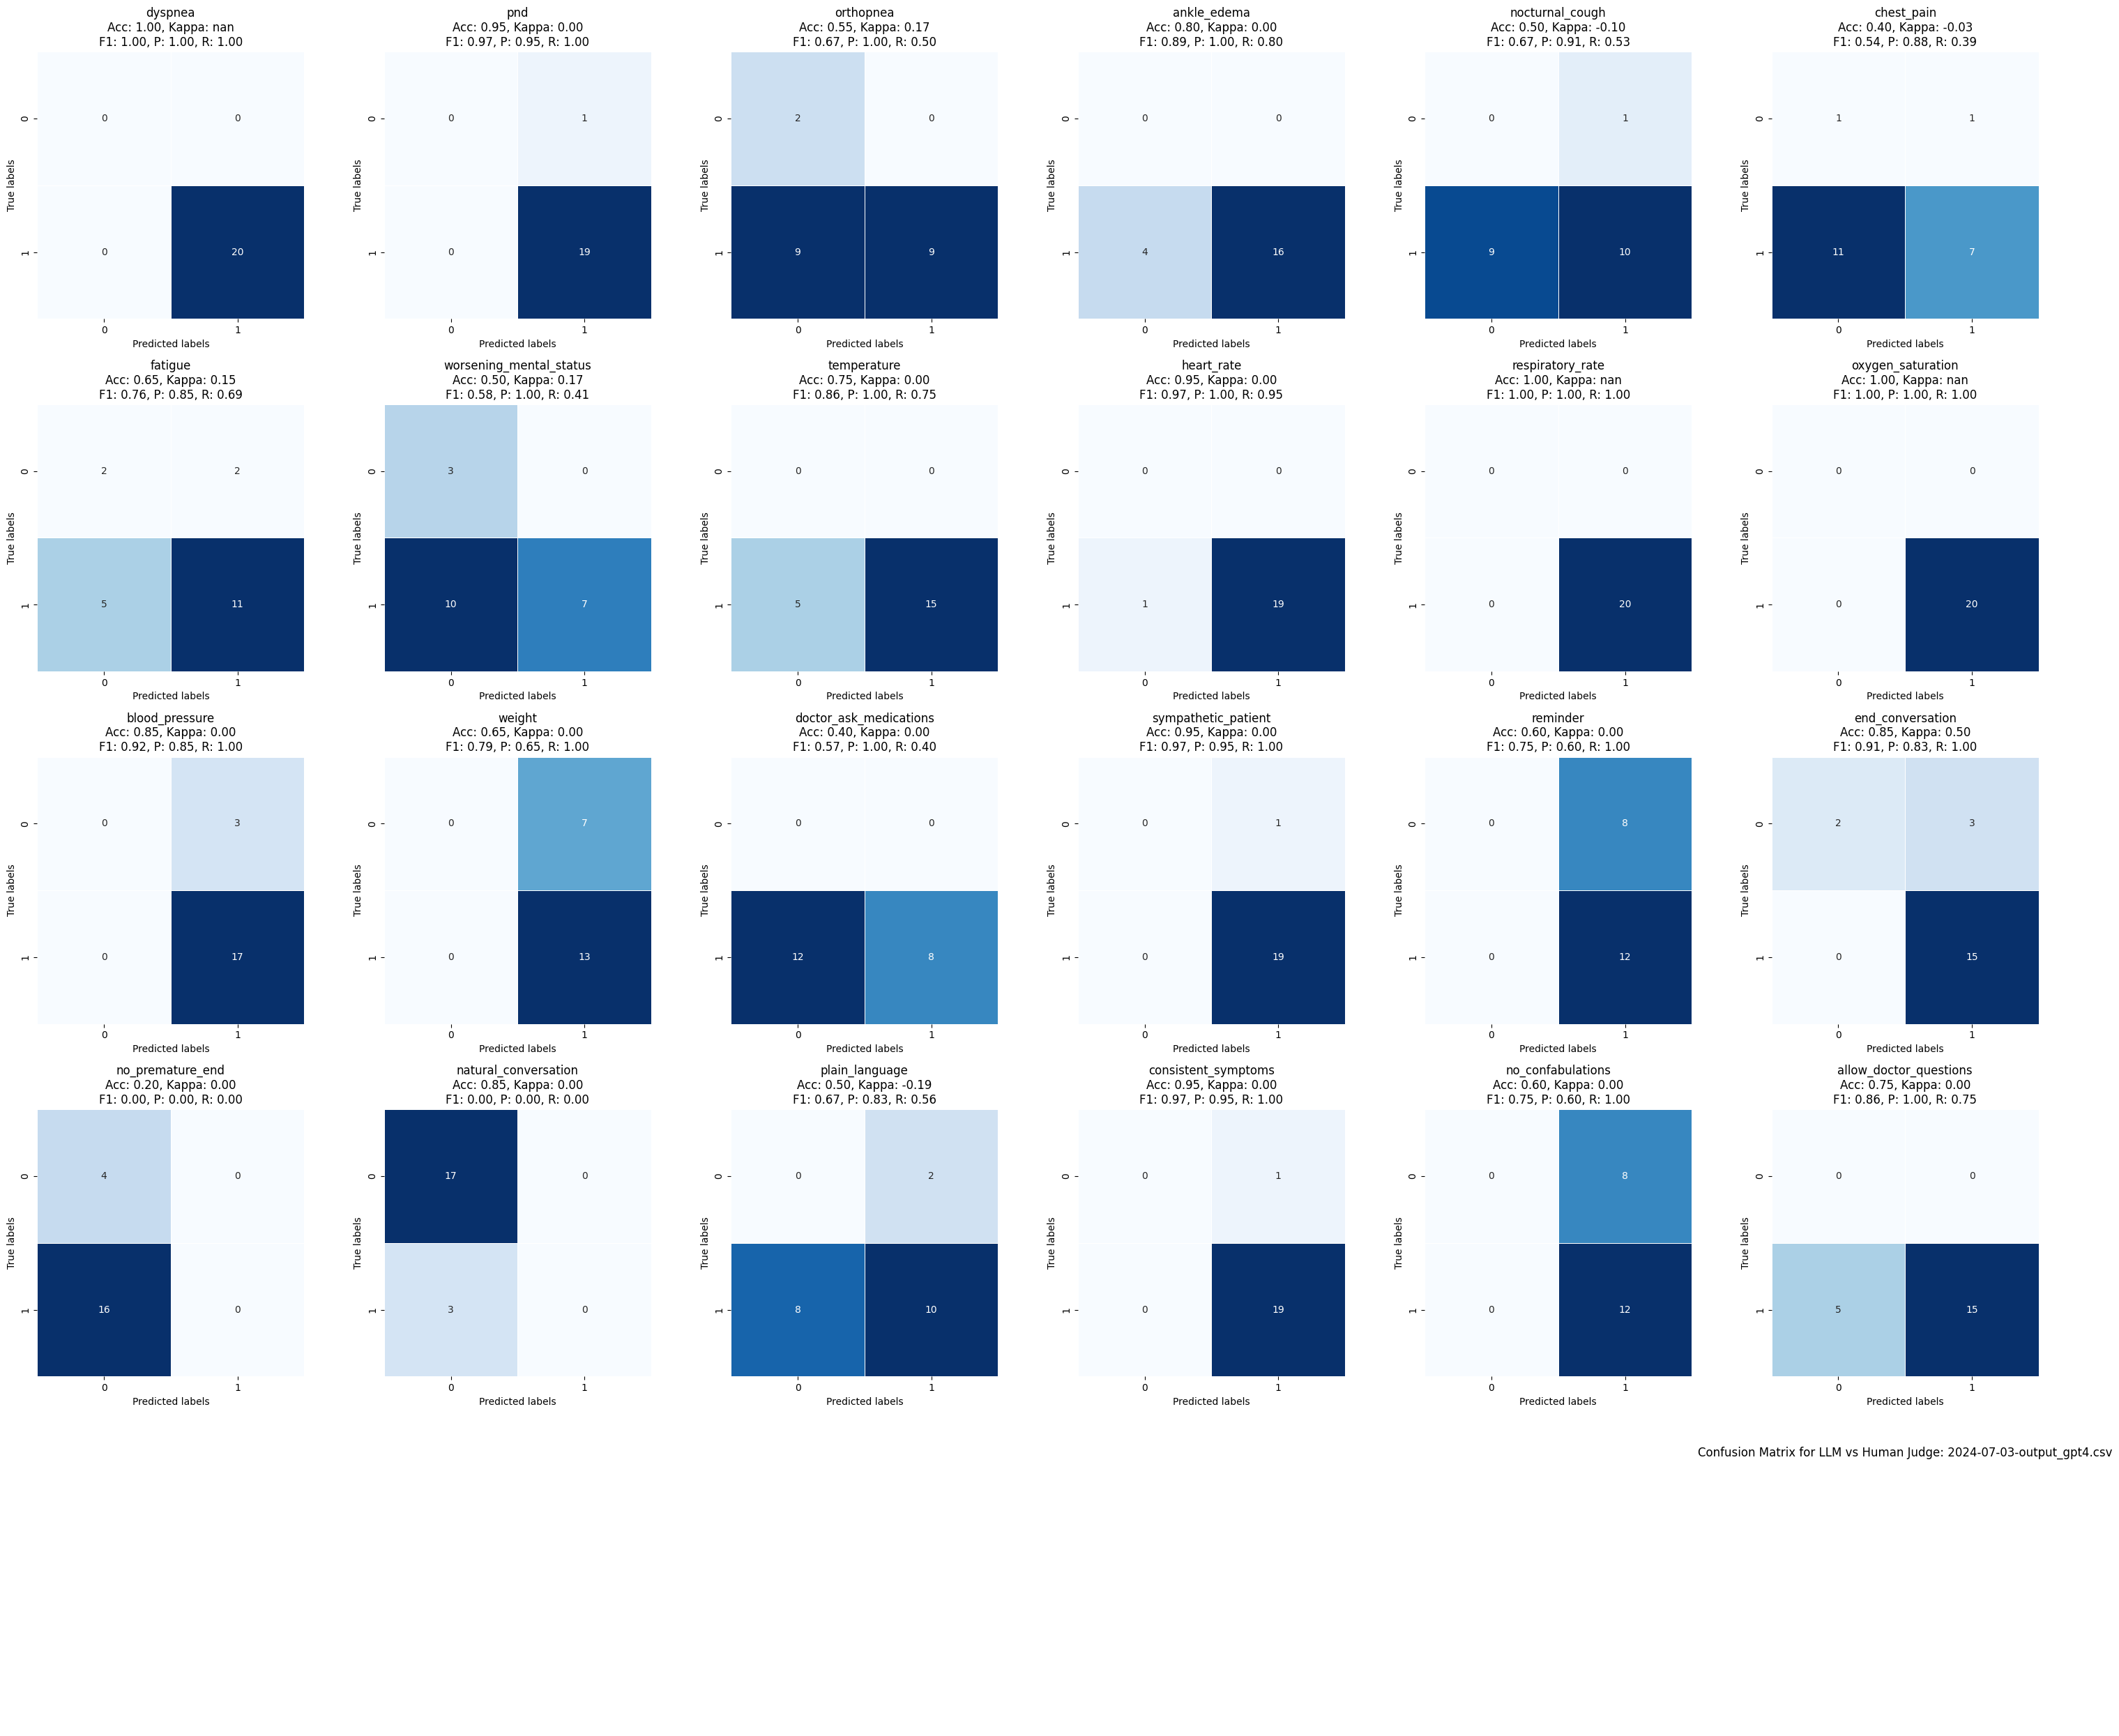

In [115]:
def plot_confusion_matrix(data_true, data_pred, columns, nrows, ncols, main_title='Confusion matrices'):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    plt.title(main_title)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        # cm = confusion_matrix(data_true[col], data_pred[col])
        tp = np.sum((data_true[col] == 1) & (data_pred[col] == 1))
        tn = np.sum((data_true[col] == 0) & (data_pred[col] == 0))
        fp = np.sum((data_true[col] == 0) & (data_pred[col] == 1))
        fn = np.sum((data_true[col] == 1) & (data_pred[col] == 0))
        accuracy = accuracy_score(data_true[col], data_pred[col])
        kappa = cohen_kappa_score(data_true[col], data_pred[col])
        precision = precision_score(data_true[col], data_pred[col])
        recall = recall_score(data_true[col], data_pred[col])
        f1 = f1_score(data_true[col], data_pred[col])

        sns.heatmap(
            [[tn, fp], [fn, tp]],
            annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', ax=axes[i], cbar=False,
        )
        axes[i].set_xlabel('Predicted labels');
        axes[i].set_ylabel('True labels');
        axes[i].set_title(f'{col}\nAcc: {accuracy:.2f}, Kappa: {kappa:.2f}\nF1: {f1:.2f}, P: {precision:.2f}, R: {recall:.2f}');

    # Hide any unused axes if there are any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout();

    return fig, axes

# Example usage for a specific column
columns_per_row = 6
fig, axes = plot_confusion_matrix(
    human_data_renamed,
    llm_data_renamed,
    [c for c in llm_data_renamed.columns if c in feature_columns],
    len(feature_columns) // columns_per_row + 1,
    columns_per_row,
    main_title=f'Confusion Matrix for LLM vs Human Judge: {llm_judge_file}'
)


## Other similarity metrics

In [110]:
# Pearson Correlation: Measures linear correlation between two datasets.
correlation = llm_data_renamed.iloc[:, 1:].corrwith(human_data_renamed.iloc[:, 1:])
print(correlation)

dyspnea                             NaN
pnd                        2.536286e-01
orthopnea                  2.500000e-01
ankle_edema                         NaN
nocturnal_cough           -1.324532e-01
chest_pain                 1.048285e-01
fatigue                   -1.666667e-01
worsening_mental_status   -2.425356e-01
temperature                         NaN
heart_rate                          NaN
respiratory_rate                    NaN
oxygen_saturation                   NaN
blood_pressure             5.461187e-01
weight                    -2.445998e-01
doctor_ask_medications              NaN
sympathetic_patient        4.588315e-01
reminder                   5.144958e-01
end_conversation          -5.233642e-17
no_premature_end           1.048285e-01
natural_conversation                NaN
plain_language            -7.647191e-02
consistent_symptoms       -5.263158e-02
no_confabulations                   NaN
allow_doctor_questions              NaN
dtype: float64


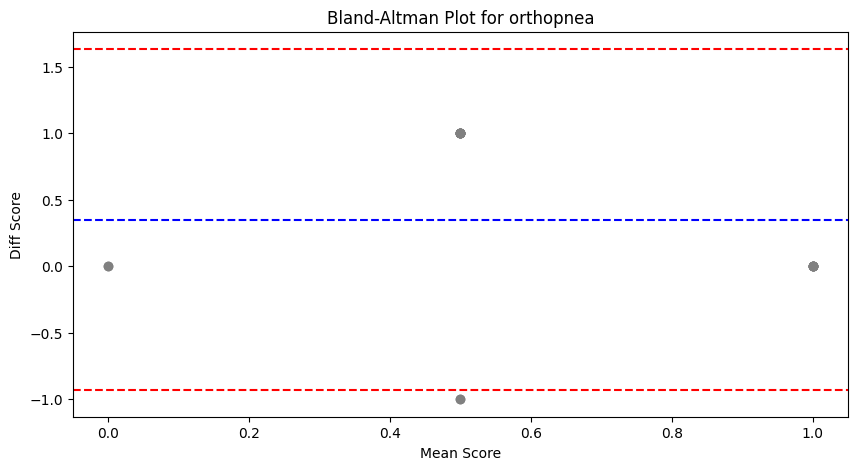

In [9]:
# Bland-Altman Plot: Used to compare two sets of measurements -- not a good measure

# You can write a function to plot Bland-Altman for a specific feature.
def bland_altman_plot(data1, data2, col):
    mean = np.mean([data1[col], data2[col]], axis=0)
    diff = data1[col] - data2[col]
    md = np.mean(diff)
    sd = np.std(diff, axis=0)

    plt.figure(figsize=(10, 5))
    plt.scatter(mean, diff, color='gray')
    plt.axhline(md, color='blue', linestyle='--')
    plt.axhline(md + 1.96 * sd, color='red', linestyle='--')
    plt.axhline(md - 1.96 * sd, color='red', linestyle='--')
    plt.title(f'Bland-Altman Plot for {col}')
    plt.xlabel('Mean Score')
    plt.ylabel('Diff Score')
    plt.show()

# Example usage
bland_altman_plot(llm_data, human_data, llm_data.columns[4])